# Passing Networks

In this notebook we will create visualisations like:

![title](https://soccermatics.readthedocs.io/en/latest/_images/ItalyEngland.png)

Here each point a player and a link means at least 13 successful passes were made between those two players in the game. Thicker lines = more passes.
- Position of the player = the avg. postition which they passed the ball in.
- A passing network = a weighted graph (in maths terms).

## Setup

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd
parser = Sbopen()

## Data

In [2]:
df, related, freeze, tactics = parser.event(69301)
team1 = "England Women's"


In [3]:
first_sub_index = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == team1].iloc[0]["index"]
mask_england = (df["type_name"] == "Pass") & (df["team_name"] == team1) & (df["index"] < first_sub_index) & (df["outcome_name"].isnull()) & (df["sub_type_name"] != "Throw-In")
df_pass = df.loc[mask_england, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: x.split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

#### Vertices size and location

In [4]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()

    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()

    scatter_df.at[i, "player_name"] = name
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

scatter_df["marker_size"] = (scatter_df["no"] / scatter_df["no"].max() * 1500)
scatter_df

,player_name,x,y,no,marker_size
0,White,84.030000,46.030000,10.0,375.0
1,Kirby,53.217241,41.262069,26.0,975.0
2,Bronze,48.309722,70.705556,40.0,1500.0
3,Parris,74.856757,67.062162,15.0,562.5
4,Moore,58.029630,37.370370,14.0,525.0
5,Mead,65.075758,15.590909,14.0,525.0
6,Greenwood,56.135088,10.507018,27.0,1012.5
7,Telford,8.493750,38.568750,12.0,450.0
8,McManus,36.892187,29.746875,34.0,1275.0
9,Scott,54.794444,53.050000,16.0,600.0


### Edge Width

In [5]:
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename(columns={"x":"pass_count"}, inplace=True)
lines_df = lines_df[lines_df["pass_count"] > 2]
lines_df

,pair_key,pass_count
0,Bronze_Houghton,18
1,Bronze_Kirby,9
2,Bronze_McManus,4
4,Bronze_Moore,5
5,Bronze_Parris,18
6,Bronze_Scott,13
7,Bronze_White,4
9,Greenwood_Kirby,8
10,Greenwood_McManus,20
11,Greenwood_Mead,17


### Plotting Vertices

In [6]:
def plot_vertices(reutrn_values=False):
    pitch = Pitch(line_color="grey")
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

    pitch.scatter(scatter_df["x"], scatter_df["y"], s=scatter_df["marker_size"], color="red", edgecolors="grey", linewidth=1, alpha=1, ax=ax["pitch"], zorder=3)

    for i, row in scatter_df.iterrows():
        pitch.annotate(row["player_name"], xy=(row["x"], row["y"]), c="black", va="center", ha="center", weight="bold", size=16, ax=ax["pitch"], zorder=4)

    fig.suptitle("Nodes Location - England")
    
    if reutrn_values:
        return pitch, fig, ax
    else:
        plt.show();

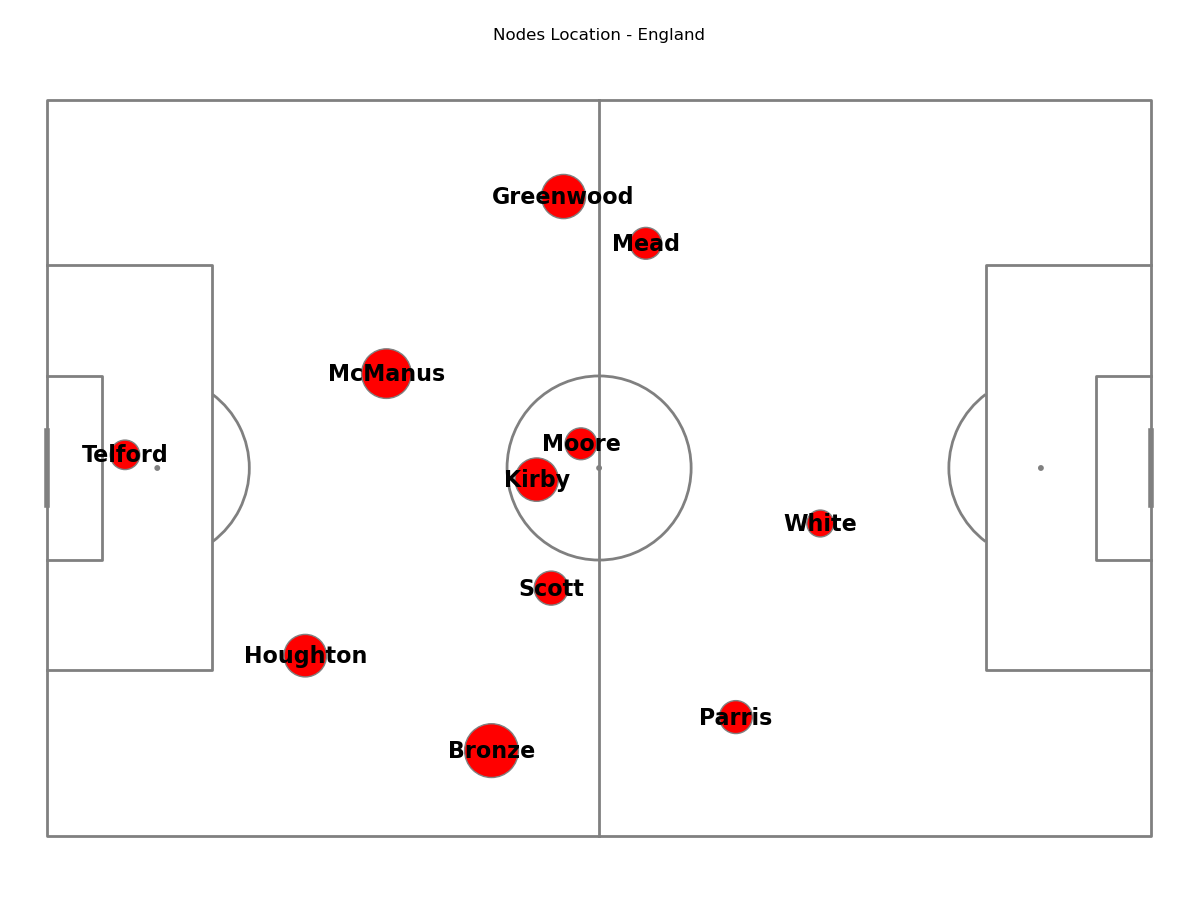

In [7]:
plot_vertices()

### Plotting Edges

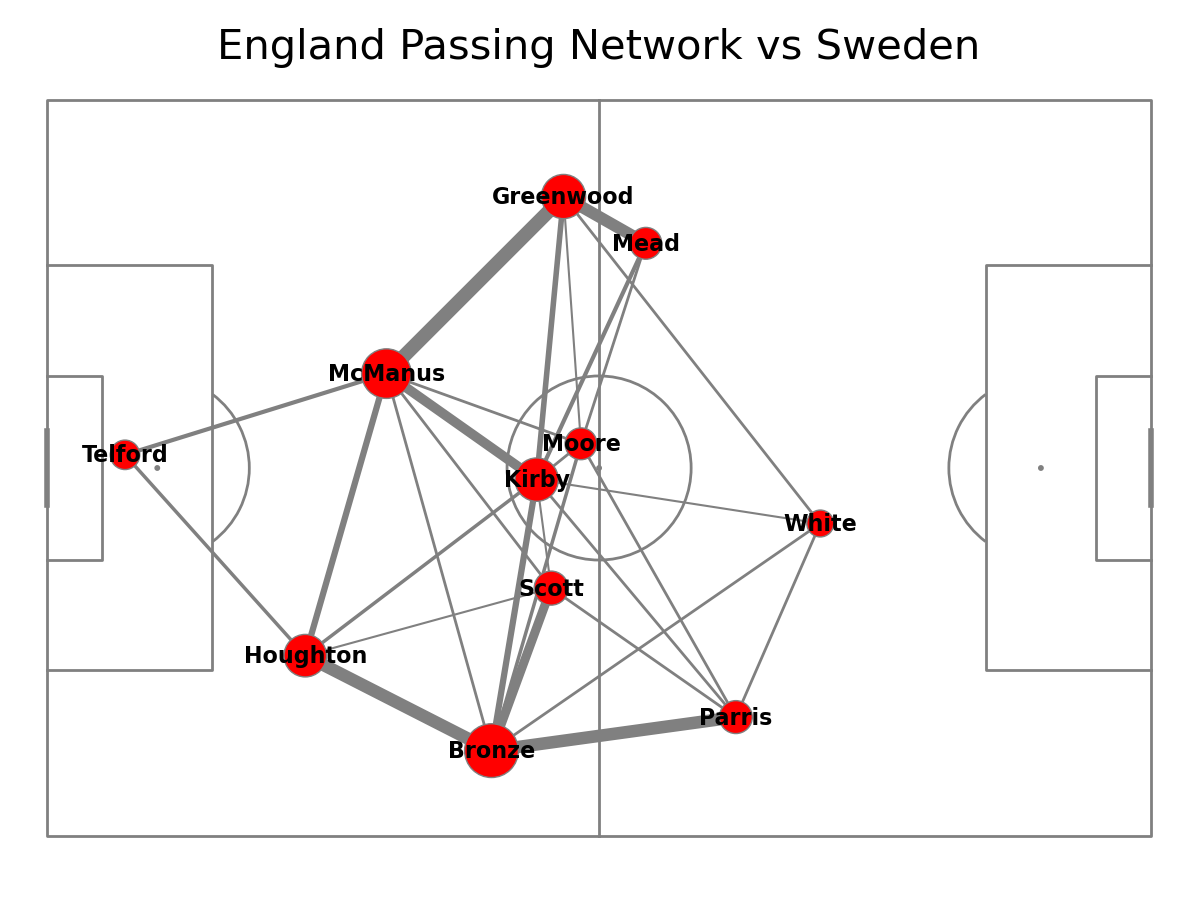

In [8]:
pitch, fig, ax = plot_vertices(True)

for i, row in lines_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row["pair_key"].split("_")[1]

    player1_x = scatter_df.loc[scatter_df["player_name"] == player1]["x"].iloc[0]
    player1_y = scatter_df.loc[scatter_df["player_name"] == player1]["y"].iloc[0]

    player2_x = scatter_df.loc[scatter_df["player_name"] == player2]["x"].iloc[0]
    player2_y = scatter_df.loc[scatter_df["player_name"] == player2]["y"].iloc[0]
    num_passes = row["pass_count"]

    line_width = (num_passes / lines_df["pass_count"].max() * 10)

    pitch.lines(player1_x, player1_y, player2_x, player2_y, alpha=1, lw=line_width, zorder=2, color="grey", ax=ax["pitch"])

fig.suptitle("England Passing Network vs Sweden", fontsize=30)
plt.show();

### Centralisation

Formula:
$$
\text{Centralisation} = \frac{\Sigma_{i=1}^N(P_* - Pi)}{(N-1) \Sigma_{i=1}^N P_i} 
$$

- $P_i = \Sigma_{j=1}^N w_{ij}$ : all the passes to player $i$
- $P_* = max(P_i)$ = Passes to the player who passed most.

[Grund (2012)](https://www.sciencedirect.com/science/article/pii/S0378873312000500) prposed this measure and found that teams with more dispered networks - less centralised, involving more players in gerneal perform better.

In [9]:
no_passes = df_pass.groupby(["player_name"])["x"].count().reset_index()
no_passes.rename(columns={"x":"pass_count"}, inplace=True)

print(no_passes)

max_no = no_passes["pass_count"].max()

denominator = 10 * no_passes["pass_count"].sum()
nominator = (max_no - no_passes["pass_count"]).sum()

centralisation_index = nominator/denominator
print(f"Centralisation Index is: {centralisation_index}")

   player_name  pass_count
0       Bronze          40
1    Greenwood          27
2     Houghton          25
3        Kirby          26
4      McManus          34
5         Mead          14
6        Moore          14
7       Parris          15
8        Scott          16
9      Telford          12
10       White          10
Centralisation Index is: 0.08884120171673819


### Challenge

Passing network with only forward passes.

In [10]:
first_sub_index = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == team1].iloc[0]["index"]
mask_england_forward_pass = (df["type_name"] == "Pass") & (df["team_name"] == team1) & (df["index"] < first_sub_index) & (df["outcome_name"].isnull()) & (df["sub_type_name"] != "Throw-In") & (df["end_x"] > df["x"])
df_forward_pass = df.loc[mask_england_forward_pass, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
df_forward_pass["player_name"] = df_forward_pass["player_name"].apply(lambda x: x.split()[-1])
df_forward_pass["pass_recipient_name"] = df_forward_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

In [11]:
forward_scatter_df = pd.DataFrame()
for i, name in enumerate(df_forward_pass["player_name"].unique()):
    
    passx = df_forward_pass.loc[df_forward_pass["player_name"] == name]["x"].to_numpy()
    passy = df_forward_pass.loc[df_forward_pass["player_name"] == name]["y"].to_numpy()

    recx = df_forward_pass.loc[df_forward_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    recy = df_forward_pass.loc[df_forward_pass["pass_recipient_name"] == name]["end_y"].to_numpy()

    forward_scatter_df.at[i, "player_name"] = name
    forward_scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    forward_scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    forward_scatter_df.at[i, "no"] = df_forward_pass.loc[df_forward_pass["player_name"] == name].count().iloc[0]

forward_scatter_df["marker_size"] = (forward_scatter_df["no"] / forward_scatter_df["no"].max() * 1500)

In [12]:
df_forward_pass["pair_key"] = df_forward_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
forward_lines_df = df_forward_pass.groupby(["pair_key"]).x.count().reset_index()
forward_lines_df.rename(columns={"x":"pass_count"}, inplace=True)
forward_lines_df = lines_df[lines_df["pass_count"] > 2]
forward_lines_df

,pair_key,pass_count
0,Bronze_Houghton,18
1,Bronze_Kirby,9
2,Bronze_McManus,4
4,Bronze_Moore,5
5,Bronze_Parris,18
6,Bronze_Scott,13
7,Bronze_White,4
9,Greenwood_Kirby,8
10,Greenwood_McManus,20
11,Greenwood_Mead,17


In [13]:
def plot_vertices(reutrn_values=False):
    pitch = Pitch(line_color="grey")
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

    pitch.scatter(forward_scatter_df["x"], forward_scatter_df["y"], s=forward_scatter_df["marker_size"], color="red", edgecolors="grey", linewidth=1, alpha=1, ax=ax["pitch"], zorder=3)

    for i, row in forward_scatter_df.iterrows():
        pitch.annotate(row["player_name"], xy=(row["x"], row["y"]), c="black", va="center", ha="center", weight="bold", size=16, ax=ax["pitch"], zorder=4)

    fig.suptitle("Nodes Location - England")
    
    if reutrn_values:
        return pitch, fig, ax
    else:
        plt.show();

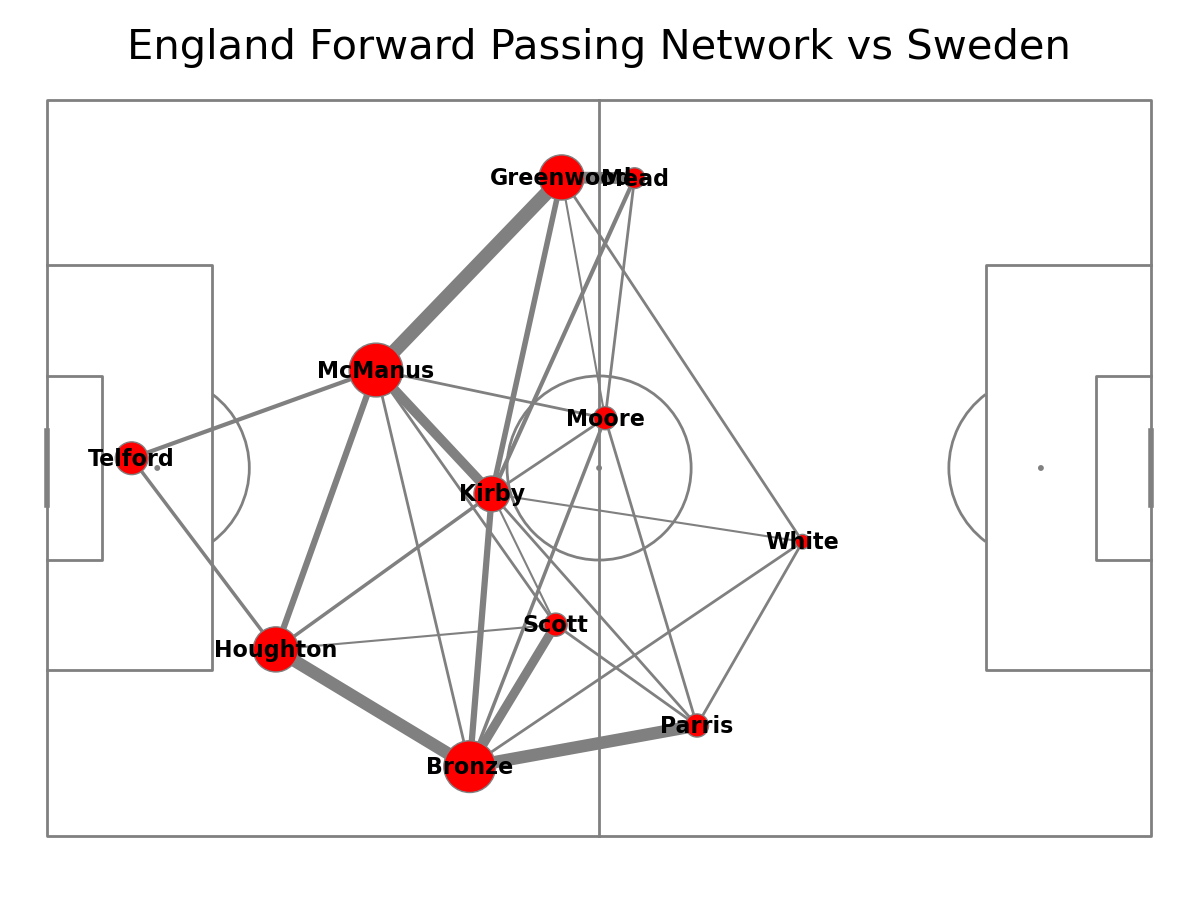

In [14]:
pitch, fig, ax = plot_vertices(True)

for i, row in lines_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row["pair_key"].split("_")[1]

    player1_x = forward_scatter_df.loc[forward_scatter_df["player_name"] == player1]["x"].iloc[0]
    player1_y = forward_scatter_df.loc[forward_scatter_df["player_name"] == player1]["y"].iloc[0]

    player2_x = forward_scatter_df.loc[forward_scatter_df["player_name"] == player2]["x"].iloc[0]
    player2_y = forward_scatter_df.loc[forward_scatter_df["player_name"] == player2]["y"].iloc[0]
    num_passes = row["pass_count"]

    line_width = (num_passes / forward_lines_df["pass_count"].max() * 10)

    pitch.lines(player1_x, player1_y, player2_x, player2_y, alpha=1, lw=line_width, zorder=2, color="grey", ax=ax["pitch"])

fig.suptitle("England Forward Passing Network vs Sweden", fontsize=30)
plt.show();

In [15]:
no_fwd_passes = df_forward_pass.groupby(["player_name"])["x"].count().reset_index()
no_fwd_passes.rename(columns={"x":"pass_count"}, inplace=True)

max_no = no_fwd_passes["pass_count"].max()

denominator = 10 * no_fwd_passes["pass_count"].sum()
nominator = (max_no - no_fwd_passes["pass_count"]).sum()

centralisation_index = nominator/denominator
print(f"Centralisation Index of forward passes is: {centralisation_index}")

Centralisation Index of forward passes is: 0.12330827067669173
